# Kaixin's 23Na(3He,d) data
See https://pfunk.readthedocs.io/en/latest/guide/bays_fit.html

### Import Packages 

In [1]:
%matplotlib inline
import pfunk
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from num2tex import num2tex
from num2tex import configure as num2tex_configure
import corner
import pickle
import numpy as np
from scipy import stats
from scipy.signal import argrelmax
import copy
import os
import pandas as pd
from datetime import datetime
from time import sleep
from tqdm import tqdm
from KaixinSpecTools import * # Some code I wrote to calculate theoretical optical model parameters from model 
from scipy.stats import uniform # This is missing in pfunk and caused a bug
np.set_printoptions(suppress=True)
num2tex_configure(display_singleton=1)
num2tex_configure(exp_format='times')

num2tex configure options:
 - help_text: boolean whether this help text is displayed when configure() is called
 - exp_format: string format specification for how the power of 10 is displayed in scientific format.
     - also accepts specifiers 'times', which is converted to '\times 10^{}', 'cdot': '\cdot 10^{}', and 'parentheses': '(10^{})'
 - display_singleton: boolean on whether the "1 \times" is printed in "1 \times 10^{p}"
          
num2tex configure options:
 - help_text: boolean whether this help text is displayed when configure() is called
 - exp_format: string format specification for how the power of 10 is displayed in scientific format.
     - also accepts specifiers 'times', which is converted to '\times 10^{}', 'cdot': '\cdot 10^{}', and 'parentheses': '(10^{})'
 - display_singleton: boolean on whether the "1 \times" is printed in "1 \times 10^{p}"
          


### Define paths, settings and parameter indices in fresco input file

In [2]:
level='10821'
# method='l=3'
method='zero_range'
# method='twol'
# method='2s12'
Notes="Read MCMC runs to fix energy inaccordance with ENSDF2022"
# method='twol'  # Try to mix two l to reproduce transfer data. This is also used for a doublet of two levels.
path_main='/home/kaixin/Documents/23NaHe3d_Analysis' # main directory
# path_specdata=path_main+'/SpecData' # directory where the datafiles are stored
path_fresco_input=path_main+'/FrescoInputFiles' # directory for fresco input files
path_fresco_data=path_main+'/FrescoInputData' # directory for yield data used for fitting optical model parameters in fresco input.
# path_mcmc=path_main+'/20221211_quick' #directory to store MCMC picle files and results
# path_mcmc=path_main+'/20221213_complete' #directory to store MCMC picle files and results
path_mcmc='/media/kaixin/BACKUP3/Kaixin\'sFolder/MCMC_runs'
# path_mcmc='/media/kaixin/KaixinRed'
# path_mcmc=path_main+'/20240614_quick'
# path_mcmc=path_main+'/100622-MCMCruns'
path_fresco_temp=path_main+'/FrescoTemp' # directory to run fresco and create temporary output files
path_log=path_main+'/RunLog/'# directory to save information of each run
# path_plots=path_main+'/Plots/'
path_plots=path_main+'/Plots/'
ambiguity=True # To resolve ambiguities according to Caleb Thesis section 6.9.2
# c0_restrain=129 # from one of my run. No big difference from Caleb's.
c0_restrain=132.9
Init_Fit=False
run_MCMC=False # Whether to immediately run MCMC in the notebook. A pickle file is saved anyway. Otherwise, use runMCMC.py to run outside.
read_quick=False

if read_quick:
    path_mcmc=path_main+'/20221211_quick' #directory to store MCMC picle files and results

# if 'twol' in method:
#     ambiguity=False # Why did I have this?
if method=='zero_range':
    method=''
else:
    method='_'+method

if 'twol' in method:
    fresco_path = path_fresco_input+'/Na23He3d_'+level+'keV'+'_twol'+'.in'
else:
    fresco_path = path_fresco_input+'/Na23He3d_'+level+'keV'+'.in'
# fresco_names = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6',
#                 'p1', 'p2', 'p3', 'p4', ('p5','p5'), ('p6','p6'),'p4']
# fresco_positions = [81, 82, 83, 84, 85, 86,
#                     115, 116, 117, 118, (119,127), (120,128), 126]
fresco_names = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6',
                'p1', 'p2', 'p3', 'p4', ('p5','p5'), ('p6','p6'),'p4']
fresco_positions = [81, 82, 83, 89, 90, 91,
                    111, 112, 113, 114, (115,123), (116,124), 122]
model_inputs = [fresco_path, fresco_names, fresco_positions]

### Create a folder with date and time to be the working path

In [3]:
now = datetime.now()
current_time = now.strftime("%Y%m%d_%H:%M")
os.chdir(path_fresco_temp)
if (os.path.exists(current_time)==False):
    os.mkdir(current_time)
os.chdir(current_time)

### Load the data. Should look like



| theta |     sigma  |  erry |
| ----| ---- | ---- |
|10    |     0.80   |  0.08 |
|15    |     0.89   |  0.09 |

In [4]:
elastic_data_path = path_fresco_data+'/23Na-3He-ES.data'
transfer_data_path = path_fresco_data+'/23Na-3He-d-'+level+'keV.data'

### Set up the model

In [5]:
model = pfunk.model.Model(fresco_path, fresco_names, fresco_positions)

## Normalization factor (exponential)
model.create_norm_prior([-10], [10.0])

## Potentials

init_3He=np.array(OptPotCal.Liang3He(Ep=21,Nt=12,Zt=11,At=23)) # To calculate from model, Otherwise should be taken from
print('3He potentials: ',init_3He)

init_2H=np.array(OptPotCal.Daehnick2H(Ex=float(level)/1000,qval=6.1992,Nt=12,Zt=12,At=24)) # Ex is in MeV


print('2H potentials: ',init_2H)

init_values=np.concatenate((init_3He,init_2H))

percents=np.array([.2]*len(init_3He)+[.1]*len(init_2H))
# init_values = np.array([117.31, 1.25, .65, 19.87, 1.25, .65,
#                         88.1, 1.17, .74, 0.3, 1.32, .73, 12.3])

# 
# [ -1.05391999   0.07106748   0.97229919   0.11420402 100.17376002
#    1.25708691   0.6836859   15.45156642   1.40616483   0.62746295
#   89.51124832   1.23554264   0.78402784   0.31671605   1.50797329
#    0.75967765  12.09616601]

# Uncertainties for the potentials
percents = np.array([.2, .2, .2, .2, .2, .2,
                     .1, .1, .1, .1, .1, .1, .1])
# model.create_pot_prior(model.fresco.x0, model.fresco.x0*percents)  # Use original params in fresco input files
model.create_pot_prior(init_values, init_values*percents)
## Scatter and Transfer scalings
model.create_scatter_prior(widths=[0.1])  ## width -> 0.01 # Scatter data scale factor
model.create_scatter_prior()  ## width -> 0.01 # Transfer data scale factor

## Spectroscopic factor
model.create_spec_prior([0.0], [1.5])  # C2S, position 1  #1.5 ->0.2 for 8358  # 0.08? in the paper
model.create_spec_prior([1.0], [0.15], gaus=True) # D0, position 2

if ('twol' in method ):
    model.create_spec_prior(0.5,0.4,mixing_percent=True) # The mixing parameter, alpha. 
    # The prior is uniform. The initial mean and width are meaningless.
## Put together
model.create_prior()
model.x0

3He potentials:  [117.36195202   1.17980052   0.75083794  19.90670811   1.20084091
   0.81604206]
2H potentials:  [87.90261553  1.17        0.73684294  0.33418006  1.325       0.73118231
 12.29165314]


array([-10.        ,   0.        ,   1.        ,   0.        ,
         0.        , 117.36195202,   1.17980052,   0.75083794,
        19.90670811,   1.20084091,   0.81604206,  87.90261553,
         1.17      ,   0.73684294,   0.33418006,   1.325     ,
         0.73118231,  12.29165314])

In [6]:
print(OptPotCal.Liang3He(Ep=21,Nt=12,Zt=11,At=23))
print(np.array(OptPotCal.Daehnick2H(Ex=float(level)/1000,qval=6.1992,Nt=12,Zt=12,At=24)) # Ex is in MeV
)

[117.36195202001942, 1.17980051886537, 0.7508379428854728, 19.906708105503107, 1.2008409091620253, 0.8160420605762478]
[87.90261553  1.17        0.73684294  0.33418006  1.325       0.73118231
 12.29165314]


### Label model parameter indices and initialize

In [7]:
iNorm = 0
iC2S  = 1
iD0=2
iScat = 3
iTrans = 4
iV=5 ## Index of first optical parameter
# iV = 4
model.x0[iNorm] = -1   ## Norm factor
model.x0[iD0] = 1 #D0
model.x0[iC2S]  = 0.08  ## C2S  
model.x0[iScat] = 0.1   ## Scat
model.x0[iTrans] = 0.1   ## Trans

if ('twol' in method):
    iAlpha=iV
    iV=iV+1
#     if level=='11453':
#         model.x0[iAlpha]=0.3018918845726638
#     elif level=='11453':
#         model.x0[iAlpha]=0.573348189362682
#     elif level=='7349':
#         model.x0[iAlpha]=0.8
#     elif level=='10059':
#         model.x0[iAlpha]=0.16132492393218895
#     elif level=='8437':
#         model.x0[iAlpha]=0.16132492393218895
#     else:
#         
    model.x0[iAlpha]=0.5

# if ('twol' in method):
#     iAlpha=4
#     model.x0[iAlpha]=0.5
#     iV=5

In [8]:
model.x0

array([ -1.        ,   0.08      ,   1.        ,   0.1       ,
         0.1       , 117.36195202,   1.17980052,   0.75083794,
        19.90670811,   1.20084091,   0.81604206,  87.90261553,
         1.17      ,   0.73684294,   0.33418006,   1.325     ,
         0.73118231,  12.29165314])

### Create likelihood functions for the ES and transfer data 

In [9]:
model.create_elastic_likelihood('fort.201', elastic_data_path, norm_index=iNorm,scatter_index=iScat)
if ('twol' in method):
    model.create_two_l_transfer_likelihood('fort.202', 'fort.203',transfer_data_path, sf_index=[iC2S,iD0], percent_index=iAlpha, norm_index=iNorm,scatter_index=iTrans)
else:
    model.create_transfer_likelihood('fort.202', transfer_data_path, [iC2S,iD0], norm_index=iNorm,scatter_index=iTrans)
#     model.create_transfer_likelihood('fort.202', transfer_data_path, [iC2S,iD0], norm_index=iNorm,scatter_index=None)
if (ambiguity):
    model.create_vr_likelihood(iV, iV+1, c0_restrain, percent=0.20, n=1.4) # mention this in the paper
model.create_likelihood()


In [10]:
model.x0 ## Check parameters

array([ -1.        ,   0.08      ,   1.        ,   0.1       ,
         0.1       , 117.36195202,   1.17980052,   0.75083794,
        19.90670811,   1.20084091,   0.81604206,  87.90261553,
         1.17      ,   0.73684294,   0.33418006,   1.325     ,
         0.73118231,  12.29165314])

In [11]:
# pwd

### Run fresco with the original values

In [12]:
model.run_fresco(model.x0)


### Plot with initial parameters

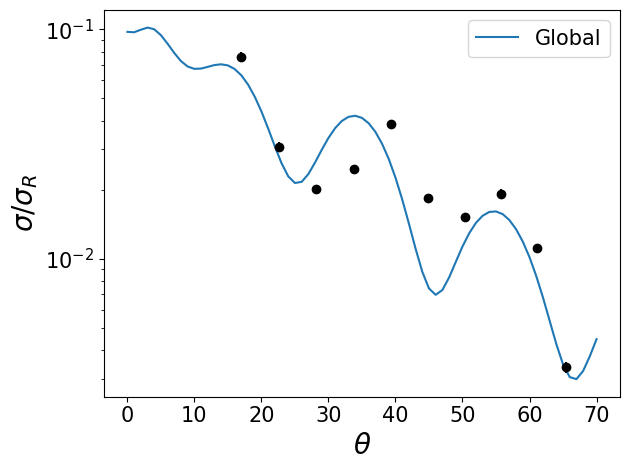

In [13]:
cs_orig = pfunk.fresco_classes.read_cross('./fort.201')
cs_orig.sigma = cs_orig.sigma
d = model.likelihood[0].data
plt.plot(cs_orig.theta, cs_orig.sigma/Minimizations.ScaleMinimize(d,cs_orig).x, label='Global', lw=1.5)
plt.errorbar(d.theta, d.sigma, d.erry, fmt='o', color='k')
plt.yscale('log')
plt.legend(fontsize=15)
plt.xticks(fontsize=15.0)
plt.yticks(fontsize=15.0)
plt.xlabel('$\\theta$', fontsize=20.0)
plt.ylabel('$\sigma/ \sigma_R$', fontsize=20.0)
plt.tight_layout()

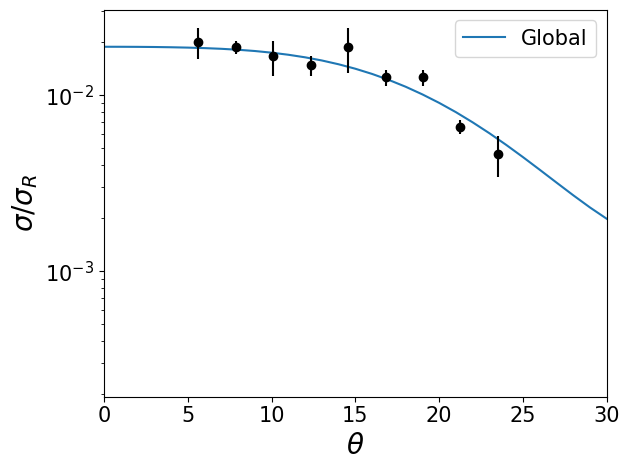

In [14]:

# model.run_fresco(model.x0)
d = model.likelihood[1].data
if ('twol' in method):
    cs_orig1 = pfunk.fresco_classes.read_cross('./fort.202')
    cs_orig2 = pfunk.fresco_classes.read_cross('./fort.203')
    [scale,alpha]=Minimizations.AlphaMinimize(d,cs_orig1,cs_orig2,LogScale=False).x
    print(alpha)
#     if (level=='7349'):
#         alpha=0.8
#         scale=1351.44694519
#     if (level=='10059'):
#         alpha=0.161
#         scale=44.95764313
#     alpha=0.8
    cs_orig1.sigma = cs_orig1.sigma/scale
    cs_orig2.sigma = cs_orig2.sigma/scale
    theta = cs_orig1.theta*alpha+cs_orig2.theta*(1-alpha)
    sigma = cs_orig1.sigma*alpha+cs_orig2.sigma*(1-alpha)
else:
    cs_orig = pfunk.fresco_classes.read_cross('./fort.202')
    cs_orig.sigma = cs_orig.sigma/Minimizations.ScaleMinimize(d,cs_orig).x
    theta = cs_orig.theta
    sigma = cs_orig.sigma
plt.plot(theta, sigma, label='Global', lw=1.5)
plt.errorbar(d.theta, d.sigma, d.erry, fmt='o', color='k')
plt.yscale('log')
plt.legend(fontsize=15)
plt.xlim([0, 30])
plt.xticks(fontsize=15.0)
plt.yticks(fontsize=15.0)
plt.xlabel('$\\theta$', fontsize=20.0)
plt.ylabel('$\sigma/ \sigma_R$', fontsize=20.0)
plt.tight_layout()


### This part is for testing, checking fresco_chi calculations

In [15]:
# testfunc=pfunk.model.LnLikeTransferTwoL('fort.202', 'fort.203',transfer_data_path, sf_index=[iC2S,iD0], percent_index=iAlpha, norm_index=iNorm,scatter_index=iScat)
# model.run_fresco(model.x0)
# pfunk.model.LnLikeTransferTwoL.norm_fresco_chi(testfunc,model.x0)

In [16]:
# from scipy.stats import norm
# # testfunc.lnlike
# # model.x0
# model.run_fresco(model.x0)
# spline1 = testfunc.cs_eval1.read_fresco()
# spline2 = testfunc.cs_eval2.read_fresco()
# theory1 = spline1(testfunc.data.theta)
# theory2 = spline2(testfunc.data.theta)
# sf=np.prod(model.x0[testfunc.sf_index])
# p = model.x0[testfunc.percent_index]
# theory_total = sf*(p*theory1 + (1.0-p)*theory2)
# likelihood = norm.logpdf(testfunc.data.sigma,
#                          loc=(theory_total),
#                          scale=testfunc.data.erry)
# likelihood = np.sum(likelihood) 
# n = 10.0**(model.x0[testfunc.i])
# theory_total = n*sf*(p*theory1 + (1.0-p)*theory2)
# print(testfunc.data.erry,'\n',
# theory_total*model.x0[testfunc.scatter_index])

In [17]:
# model.run_fresco(model.x0)
# pfunk.model.LnLikeTransferTwoL.norm_fresco_chi(testfunc,model.x0)


In [18]:

model.x0

array([ -1.        ,   0.08      ,   1.        ,   0.1       ,
         0.1       , 117.36195202,   1.17980052,   0.75083794,
        19.90670811,   1.20084091,   0.81604206,  87.90261553,
         1.17      ,   0.73684294,   0.33418006,   1.325     ,
         0.73118231,  12.29165314])

### Update initial value of mixing ratio alpha based on rough optimization

In [19]:
if ('twol' in method and alpha<1):
    model.x0[iAlpha]=alpha

### Do initial fit

In [20]:
if (Init_Fit):
# Initial fit before MCMC
    fit = pfunk.model_fit.MAPFit(model, percent_range=.2)
    fit.run_anneal(max_iter=100)
    # fit.single_run()
    print("\n finished")
    print(fit.x0_custom)
    print(fit.results.x)

### Save model parameters and input files

In [21]:
logdir=path_log+current_time+'_'+level+'_'+method
if (os.path.exists(logdir)==False):
    os.mkdir(logdir)
    
fp = open(logdir+'/ModelParams.txt', 'w')
if (Init_Fit):
    fp.write("Initial fit.x0_custom values:\n")
    for value in fit.x0_custom:
        fp.write(str(value))
        fp.write('\t')
    fp.write('\n')    
    fp.write("Fitted fit.results.x values:\n")
    for value in fit.results.x:
        fp.write(str(value))
        fp.write('\t')
    print('Done')
else:
    fp.write("Initial fit.x0_custom values:\n")
    for value in model.x0:
        fp.write(str(value))
        fp.write('\t')
    fp.write('\n')    
fp.close()

fp = open(logdir+'/Notes.txt', 'w')
fp.write(Notes)
fp.close()

fp = open(path_log+'/Log.txt', 'a')
fp.write(current_time)
fp.write('\t')
fp.write(level)
fp.write('\t')
if (Init_Fit):
    fp.write(str(fit.results.x[iC2S]))
    fp.write('\t')
fp.write(Notes)
fp.write('\n')
fp.close()

os.system('cp '+fresco_path+' '+logdir+'/input.txt')
os.system('cp '+elastic_data_path+' '+logdir+'/ES.txt')
os.system('cp '+transfer_data_path+' '+logdir+'/Trans.txt')

0

### Update model parameters with fitted values and plot again

In [22]:
if (Init_Fit):
#     fit.results.x=abs(fit.results.x)
    model.x0=fit.results.x
    model.run_fresco(model.x0)
    cs_orig = pfunk.fresco_classes.read_cross('./fort.201')
    d = model.likelihood[0].data
    scale_ES=Minimizations.ScaleMinimize(d,cs_orig)
    plt.plot(cs_orig.theta, cs_orig.sigma/scale_ES.x, label='ES', lw=1.5)
    plt.errorbar(d.theta, d.sigma, d.erry, fmt='o', color='k')
    plt.yscale('log')
    plt.show()
    model.run_fresco(model.x0)
    d = model.likelihood[1].data
    if ('twol' in method):
        cs_orig1 = pfunk.fresco_classes.read_cross('./fort.202')
        cs_orig2 = pfunk.fresco_classes.read_cross('./fort.203')
#         [scale,alpha]=Minimizations.AlphaMinimize(d,cs_orig1,cs_orig2)
#         cs_orig1.sigma = cs_orig1.sigma/scale
#         cs_orig2.sigma = cs_orig2.sigma/scale
#         theta = cs_orig1.theta*alpha+cs_orig2.theta*(1-alpha)
#         sigma = cs_orig1.sigma*alpha+cs_orig2.sigma*(1-alpha)
        alpha=model.x0[iAlpha]
        theta = cs_orig1.theta
        sigma = (cs_orig1.sigma*alpha+cs_orig2.sigma*(1-alpha))*10**model.x0[iNorm]*model.x0[iC2S]
        print(alpha)
    else:
        cs_orig = pfunk.fresco_classes.read_cross('./fort.202')
        scale_trans=Minimizations.ScaleMinimize(d,cs_orig)
        cs_orig.sigma = cs_orig.sigma/scale_trans.x
        theta = cs_orig.theta
        sigma = cs_orig.sigma
    plt.plot(theta[0:30], sigma[0:30], label='Trans', lw=1.5)
    plt.errorbar(d.theta, d.sigma, d.erry, fmt='o', color='r')
    plt.yscale('log')
    plt.legend()

In [23]:
# print('C2S =',scale_ES/scale_trans)

### Set up the sampler
Make sure it looks ok

In [24]:
sampler = pfunk.sampler.Sampler(model)
sampler.nwalker = 400   #500 # Caleb: 400
sampler.nstep = 8000 #1500 # Caleb: 8000
if (run_MCMC or read_quick): 
    sampler.nwalker = 300 #150
    sampler.nstep=1000 # 300, Fewer nsteps for a test run
sampler.ball_init() # scatter walks around initial value
# sampler.cont_init() # scatter walks around initial value with Vr**n = c relationship
# if ('twol' in method):
#     sampler.cont_init(lower=1.15, upper=1.55)

In [25]:
# sampler.check_p0() # make sure values are finite. Usually be between -200 and -400 if transfer scale is initialized to =0.1.


### We can now save the model and run it separately

In [26]:
# Write to file
# if (not run_MCMC):
f_myfile = open(path_mcmc+'/Model-'+level+method+'.pickle', 'wb')
pickle.dump(model, f_myfile)
f_myfile.close()

In [27]:
# if (not run_MCMC):
#     stop
# with np.printoptions(threshold=np.inf):
#     print(sampler.p0)


----

## Run emcee!
I suggest doing this somewhere outside of Jupyter. See the runMCMC.py script

In [28]:
if (run_MCMC):
    sampler.run_ensemble() # now run emcee

In [29]:
if (run_MCMC):
## Save the output
    np.save(path_mcmc+'/samples-'+level+'-new.npy', sampler.sampler.get_chain())

----

## Now load the saved data!

In [30]:
#Read from file
# f_myfile = open('Model-8437.pickle', 'rb')
# tmp = pickle.load(f_myfile)  # variables come out in the order you put them in
# f_myfile.close()
if (run_MCMC):
    samples = np.load(path_mcmc+'/samples-'+level+'-new.npy')
elif (method=='_'):
    samples = np.load(path_mcmc+'/samples-'+level+'.npy')
else:
    samples = np.load(path_mcmc+'/samples-'+level+method+'.npy')
#     samples = np.load(path_mcmc+'/samples-'+level+'.npy')
# samples = np.load(path_mcmc+'/samples-'+level+'-new.npy')
# samples = np.load(path_mcmc+'/samples-'+level+'-new.npy')
# samples = np.load(path_mcmc+'/samples-11453-new.npy')

### Statistics for loaded data 

In [31]:
print('There are {} dimensions'.format(samples.ndim))
print('Number of fit parameters is ',len(samples[1,1,:]))
print('Number of chains is ',len(samples[1,:,1]))
print('Number of steps is ',len(samples[:,1,1]))
print('\nFor example, to get parameters for sample 5 of chain 2 (starting at 0), get samples[5,2,:]')
print(samples[5,2,:])

There are 3 dimensions
Number of fit parameters is  18
Number of chains is  400
Number of steps is  8000

For example, to get parameters for sample 5 of chain 2 (starting at 0), get samples[5,2,:]
[ -0.98711244   0.04799199   1.00642955   0.09257613   0.07161086
 117.34704608   1.1716114    0.74566923  19.93798783   1.19361075
   0.83452505  87.89639746   1.15106669   0.72669506   0.32875872
   1.32322915   0.73166829  12.26701846]


### Slice and thin the data

In [32]:
Nchains=int(len(samples[1,:,1]))
Nstep=(len(samples[:,1,1]))

In [33]:
## Step 1 - discard the first Ndiscard samples from each chain
Ndiscard = int(Nstep*3/4) #500
# if (run_MCMC or read_quick):
#     Ndiscard=100
sliced_samples = samples[Ndiscard:,:,:]

## Step 2 - thin by Nthin
Nthin = 20 #20
if (run_MCMC or read_quick):
    Nthin=5
thinned_samples = sliced_samples[int(Nthin/2)::Nthin,:]

## Step 3 - flatten the chains
flattened_samples = thinned_samples.reshape(-1,sliced_samples.shape[-1])

### Plot a parameter for debugging (colors represent chains)

In [34]:
## Plot one parameter
ipar = iC2S
# plt.figure(figsize=(9.5, 6.5))
# plt.plot(samples[0:,:,ipar], alpha=0.3)
# # plt.title('C2S'.format(ipar))
# plt.xlabel('Number of steps',fontsize=25)
# plt.ylabel('$C^2S$',fontsize=25)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.yscale('log')
# plt.ylim(100,120)
# plt.ylim(0,0.15)
# plt.savefig(path_plots+'/'+level+'_C2S_chain.png')

### Animation of a chain

In [35]:

print(model.x0,'\n',samples[10,0,:])


[ -1.           0.08         1.           0.1          0.1
 117.36195202   1.17980052   0.75083794  19.90670811   1.20084091
   0.81604206  87.90261553   1.17         0.73684294   0.33418006
   1.325        0.73118231  12.29165314] 
 [ -0.98695619   0.05792771   1.00153314   0.10796211   0.12264837
 117.35023496   1.16063469   0.74351501  19.89937067   1.20471901
   0.80474696  87.8993557    1.19665033   0.76293834   0.34107524
   1.32670961   0.73240195  12.29181628]


In [36]:
# import matplotlib.animation as animation
# fig, ax = plt.subplots()
# d = model.likelihood[0].data
# x=cs_orig.theta
# plt.yscale('log')
# ax.errorbar(d.theta, d.sigma, d.erry, fmt='o', color='k')
# line, = ax.plot(x, cs_orig.sigma)
# chain=0
# def animate(nstep):
#     model.x0=samples[nstep,chain,:]
#     model.run_fresco(model.x0)
#     cs_ES = pfunk.fresco_classes.read_cross('./fort.201')
#     line.set_ydata(cs_ES.sigma*10**(samples[nstep,chain,iNorm]))  # update the data.
#     return line,
# ani = animation.FuncAnimation(
#     fig, animate, interval=20, blit=True, save_count=300)
# ani.save("movie.gif")

### Plot all chains

In [37]:

# fig, axes = plt.subplots(samples.shape[-1], figsize=(6, 20), sharex=True)
# for i in range(samples.shape[-1]):
#     ax = axes[i]
#     ax.plot(samples[:, :, i], alpha=0.3)
#     ax.set_xlim(0, len(samples))
#     ax.yaxis.set_label_coords(-0.1, 0.5)

# axes[-1].set_xlabel("step number");
# plt.savefig(path_plots+'/'+level+'_chains.png')

In [38]:
print(samples.shape)
print(sliced_samples.shape)
print(thinned_samples.shape)
print(flattened_samples.shape)

(8000, 400, 18)
(2000, 400, 18)
(100, 400, 18)
(40000, 18)


### Get a bunch of samples

In [39]:
# s = flattened_samples
#s = sampler.sampler.get_chain(flat=True, discard=50, thin=20) #500, 20 get samples remove burn in and thin.

### Filter out diverged chains.

In [40]:
s = flattened_samples
snew=[]
upperlim=np.average(np.percentile(s[:, 1], [16, 50, 84]))+\
    4*np.diff(np.percentile(s[:, 1], [16, 50, 84]))[1]
# if (level=='7349'):
#     upperlim=0.03
# if (level=='7555'):
#     upperlim=0.01
# if (level=='8358'):
#     upperlim=0.017
# if (level=='9146'):
#     upperlim=0.03
# if (level=='8864'):
#     upperlim=0.2
# if (level=='10333'):
#     upperlim=0.01
# if (level=='10821'):
#     upperlim=0.05
# if (level=='10917'):
#     upperlim=0.06
# if (level=='11695'):
#     upperlim=0.035
# if (level=='11518'):
#     upperlim=0.1
for i in range(0,len(s)):
#     Filter=(s[i,iTrans]<0.04 and s[i,iTrans]>0)
    Filter=s[i,iC2S]<upperlim and s[i,iC2S]>0 and s[i,iV]*s[i,iV+1]**1.14 >100 and s[i,iV]*s[i,iV+1]**1.14 <150
    if(Filter):
        snew.append(s[i,:])
print('Filter out diverged chains.')
print('Discarded: %d/%d' % (len(s)-len(snew),len(s)))
s=np.array(snew)


Filter out diverged chains.
Discarded: 1589/40000


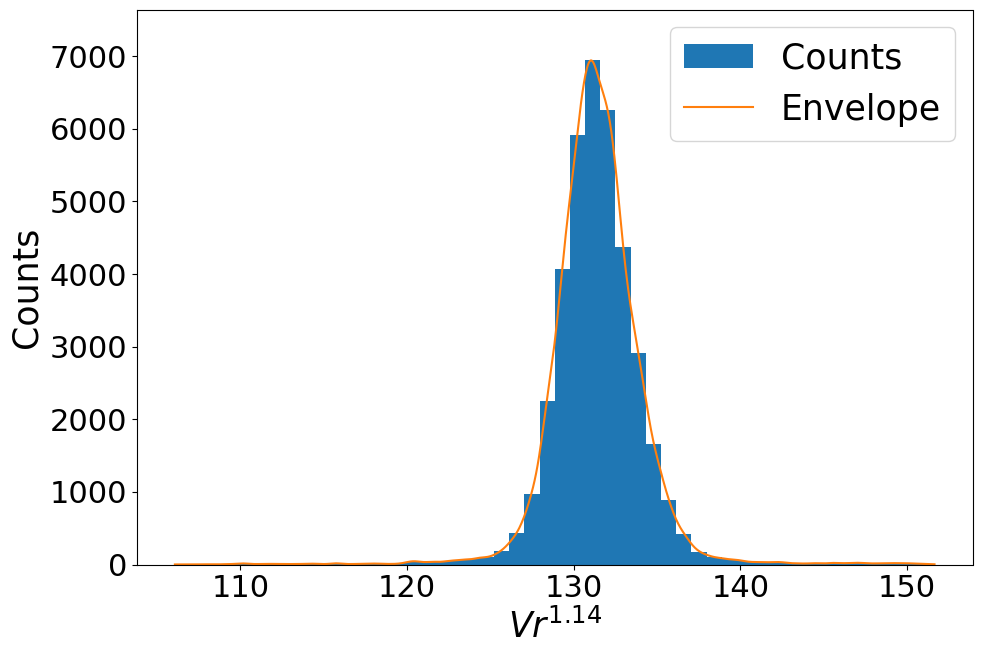

In [41]:
vr=[]
for i in range(0,len(s)):
    vr.append(s[i,iV]*s[i,iV+1]**1.2)
    
plt.figure(figsize=(9.5, 6.5))
xx = np.linspace(min(vr), max(vr), 1000)
kde = stats.gaussian_kde(vr)
h = plt.hist(vr,50,label='Counts')
# xx = np.linspace(0,0.1, 1000)
# kde = stats.gaussian_kde([x for x in s[:,ipar] if (x<0.1 and x>0)])
# h = plt.hist([x for x in s[:,ipar] if (x<0.1 and x>0)], 100)
scale = max(h[0])/max(kde(xx))
plt.plot(xx,scale*kde(xx),label='Envelope')

plt.xlabel('$Vr^{1.14}$',fontsize=25)
plt.ylabel('Counts',fontsize=25)
plt.tight_layout()
plt.ylim(0,max(h[0]*1.1))
plt.legend(fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# plt.savefig(path_plots+'/'+level+'_C2S.png')
plt.show()

### Draw a corner plot

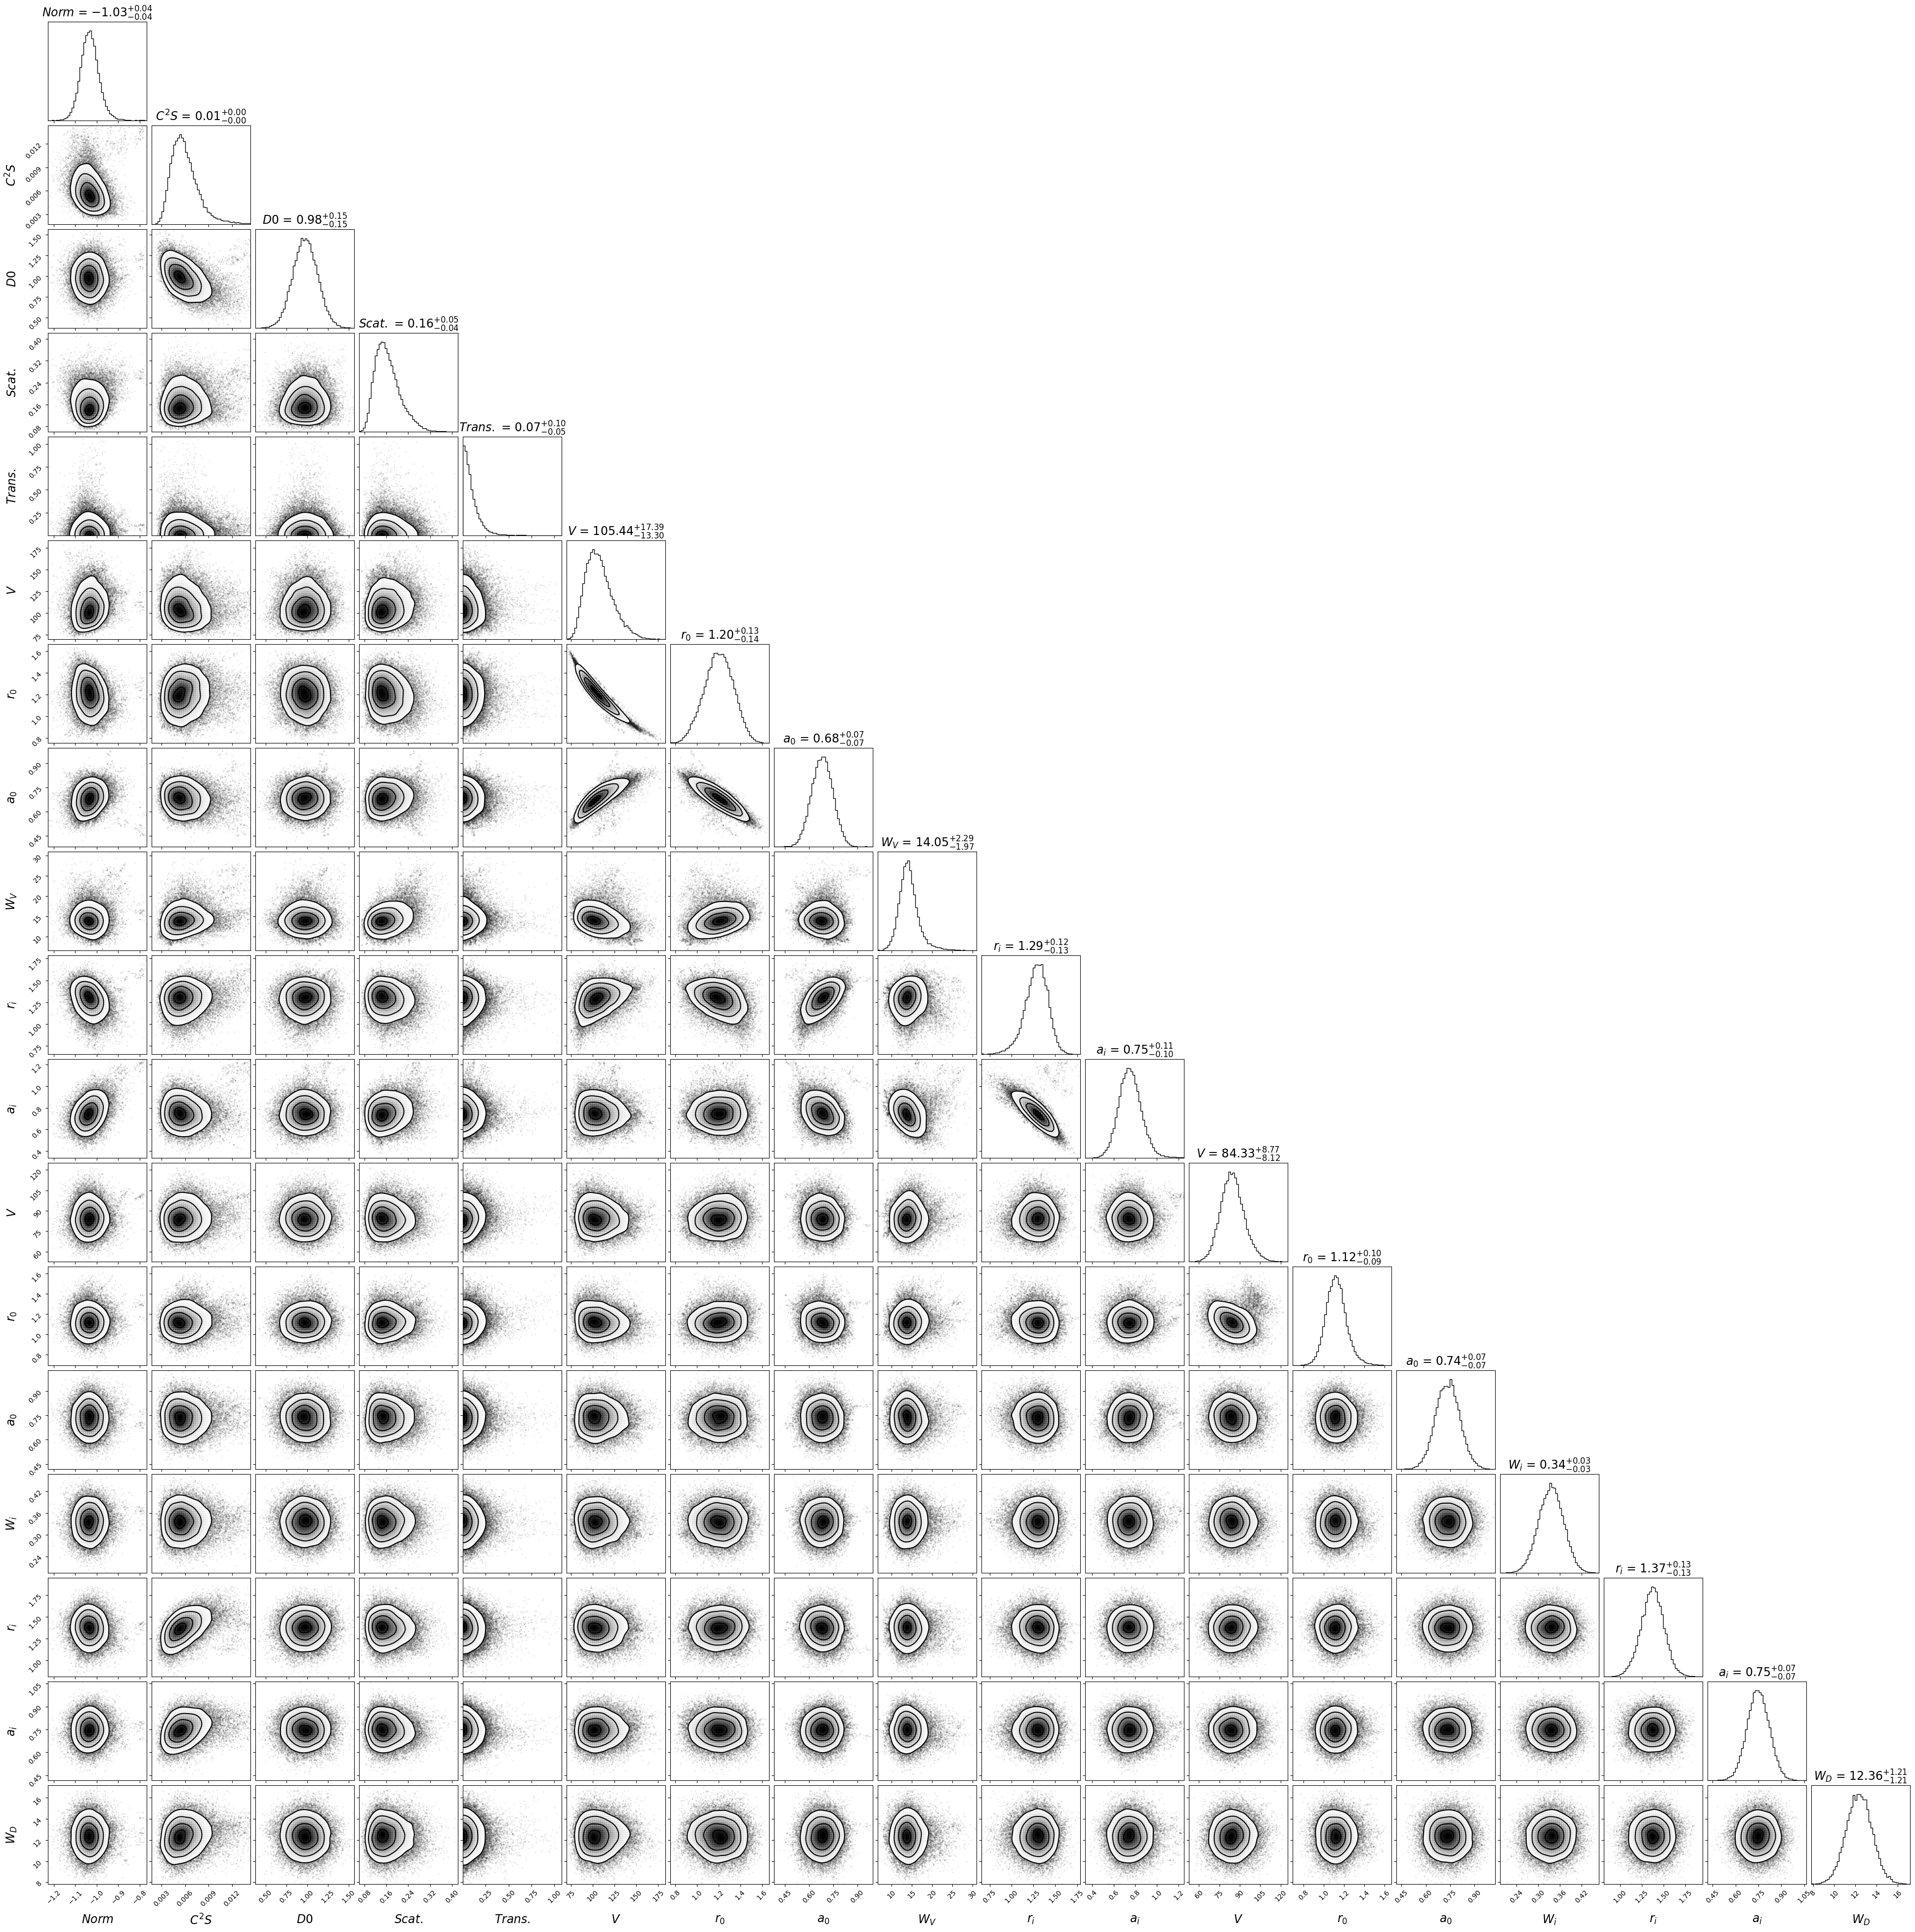

In [61]:
if ('twol' in method):
#     labels = ['$Norm$','$C^2S$','$D0$','$Scat.$','$alpha$','$V$', '$r_0$', '$a_0$', '$W_V$','$r_i$', '$a_i$', 
#          '$a_i$','$V$','$r_0$','$a_0$','$W_V$','$r_i$', '$a_i$','$W_S$']
    labels = ['$Norm$','$C^2S$','$D0$','$Scat.$','$Trans.$','$alpha$','$V$', '$r_0$', '$a_0$', '$W_V$','$r_i$', '$a_i$', 
         '$V$','$r_0$','$a_0$','$W_i$','$r_i$', '$a_i$','$W_D$']
else:
    labels = ['$Norm$','$C^2S$','$D0$','$Scat.$','$Trans.$','$V$', '$r_0$', '$a_0$', '$W_V$', '$r_i$', '$a_i$',
         '$V$','$r_0$','$a_0$','$W_i$','$r_i$', '$a_i$', '$W_D$']
#     labels = ['$Norm$','$C^2S$','$D0$','$Scat.$','$V$', '$r_0$', '$a_0$', '$W_V$', '$r_i$', '$a_i$',
#          '$V$','$r_0$','$a_0$','$W_V$','$r_i$', '$a_i$','$W_S$']
p = corner.corner(s, bins=50
                  , smooth=1.5, labels=labels,
                  show_titles=True, title_kwargs={'fontsize':17.0},
                  label_kwargs={'fontsize':17.0})
plt.savefig(path_plots+'/'+level+'_corner.png')

### Plot the histogram for a single parameter

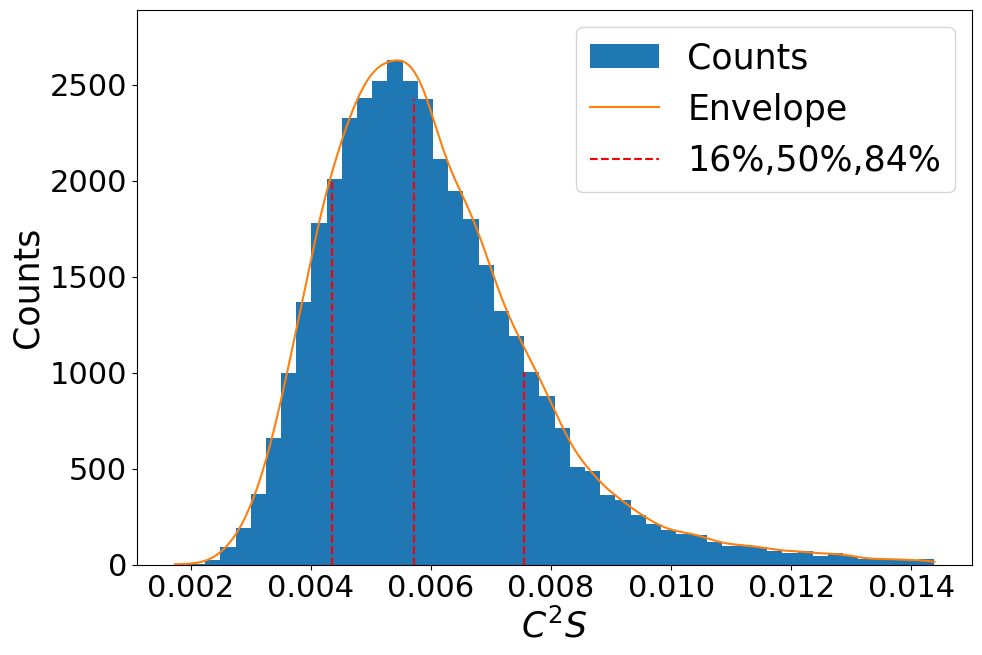

In [43]:
ipar = iC2S
plt.figure(figsize=(9.5, 6.5))
xx = np.linspace(min(s[:,ipar]), max(s[:,ipar]), 1000)
kde = stats.gaussian_kde(s[:,ipar])
h = plt.hist(s[:,ipar],50,label='Counts')
# xx = np.linspace(0,0.1, 1000)
# kde = stats.gaussian_kde([x for x in s[:,ipar] if (x<0.1 and x>0)])
# h = plt.hist([x for x in s[:,ipar] if (x<0.1 and x>0)], 100)
scale = max(h[0])/max(kde(xx))
plt.plot(xx,scale*kde(xx),label='Envelope')
cuts=np.percentile(s[:, ipar], [16, 50, 84])
y=h[0][(np.abs(h[1] - cuts[0])).argmin()]
plt.plot([cuts[0], cuts[0]], [0, y], color = 'red',linestyle='--')
y=h[0][(np.abs(h[1] - cuts[1])).argmin()]
plt.plot([cuts[1], cuts[1]], [0, y], color = 'red',linestyle='--')
y=h[0][(np.abs(h[1] - cuts[2])).argmin()]
plt.plot([cuts[2], cuts[2]], [0, y], color = 'red', label = '16%,50%,84%',linestyle='--')
#plt.xlim(0,0.2)

plt.xlabel(labels[ipar],fontsize=25)
plt.ylabel('Counts',fontsize=25)
plt.tight_layout()
plt.ylim(0,max(h[0]*1.1))
plt.legend(fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.savefig(path_plots+'/'+level+'_C2S.png')
plt.show()


In [44]:
## This code is used to test ambiguity and subtract correct c0. No longer useful.

# if (ambiguity):
#     z=[]
#     for i in range(0,len(s[:,3])):
#             z.append(s[:,3][i]*s[:,4][i]**1.14)
#     h = plt.hist(z, 100)
#     plt.xlabel('c_0',fontsize=15)
#     xx = np.linspace(min(z), max(z), 1000)
#     kde2 = stats.gaussian_kde(z)
#     scale = max(h[0])/max(kde2(xx))
#     plt.plot(xx,scale*kde2(xx))
#     listc0p=np.array(argrelmax(kde2(xx),order=50))/1000*(xx[-1]-xx[0])+xx[0]
#     listc0p=list(listc0p[0])
#     listc0=list(kde2(listc0p))
#     c0_1=listc0p[listc0.index(max(listc0))]
#     listc0.remove(max(listc0))
#     listc0p.remove(c0_1)
#     c0_2=listc0p[listc0.index(max(listc0))]
#     print('maximums for c0:',c0_1,c0_2)
#     snew=[]
#     for i in range(0,len(s)):
#         if(z[i]>0.7*c0_1 and z[i]<1.3*c0_1):
#             snew.append(s[i,:])
# if (ambiguity):
#     s=np.array(snew)
#     p = corner.corner(np.array(snew), bins=50, smooth=1.5, labels=labels,
#                       show_titles=True, title_kwargs={'fontsize':17.0},
#                       label_kwargs={'fontsize':17.0})

### Print out the final results

In [45]:

from IPython.display import display, Math
ndim = s.shape[-1]
for i in range(ndim):
    mcmc = np.percentile(s[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{3} = ${0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Print in a copiable format

In [46]:
for i in range(ndim):
    mcmc = np.percentile(s[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{3} = ${0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    print(txt)
#print(s[1000,:])



$Norm$ = $-1.033_{-0.039}^{0.042}$
$C^2S$ = $0.006_{-0.001}^{0.002}$
$D0$ = $0.978_{-0.146}^{0.149}$
$Scat.$ = $0.158_{-0.037}^{0.052}$
$Trans.$ = $0.068_{-0.049}^{0.095}$
$V$ = $105.442_{-13.304}^{17.395}$
$r_0$ = $1.202_{-0.137}^{0.134}$
$a_0$ = $0.681_{-0.066}^{0.065}$
$W_V$ = $14.045_{-1.967}^{2.288}$
$r_i$ = $1.290_{-0.135}^{0.119}$
$a_i$ = $0.748_{-0.098}^{0.105}$
$V$ = $84.335_{-8.123}^{8.773}$
$r_0$ = $1.118_{-0.094}^{0.099}$
$a_0$ = $0.736_{-0.074}^{0.073}$
$W_i$ = $0.336_{-0.034}^{0.034}$
$r_i$ = $1.373_{-0.131}^{0.126}$
$a_i$ = $0.748_{-0.071}^{0.073}$
$W_D$ = $12.358_{-1.211}^{1.214}$


### Run Fresco again on the samples in s

In [47]:
N = 100
s_samp = s[np.random.choice(s.shape[0],N),:]
all_cs_elastic = []
all_cs_transfer = []
all_cs_transfer_l2 = []
ANCs=[]
C2S_results=[]
ANC_results=[]
Ref=pd.read_csv(path_mcmc+'/C2S_Results',sep='\t')
lcolor = ['#9BEFA5','#F5B82E','#C08497','#9E2B25','#B4E1FF']
if level.find('_')>=0:
    levelnum=int(level[0:level.find('_')])
else:
    levelnum=int(level)
for i in tqdm(range(N)):
    ele=s_samp[i]
    model.run_fresco(ele)
    cs_elastic_temp = pfunk.fresco_classes.read_cross('fort.201')
    cs_transfer_temp = pfunk.fresco_classes.read_cross('fort.202')
    if ('twol' in method):
        cs_transfer_temp2 = pfunk.fresco_classes.read_cross('fort.203')
        all_cs_transfer_l2.append(cs_transfer_temp2)
    all_cs_elastic.append(cs_elastic_temp)
    all_cs_transfer.append(cs_transfer_temp)
    
data=pd.read_csv('fort.46',index_col=False,lineterminator='\n',sep='\s+',header=None,names=['R','ANC','Unknown1','Unknown2','Unknown3','Unknown4'])

if ('twol' in method):
    ANC_results.append(level+'\t'+str(data['ANC'][0]))
    ANC_results.append(level+'\t'+str(data['ANC'][1]))
    s1=np.percentile(s[:, iC2S]*s[:, iAlpha], [16, 50, 84])
    s2=np.percentile(s[:, iC2S]*(1-s[:, iAlpha]), [16, 50, 84])
    txt = "{3} = ${0:.4f}_{{{1:.4f}}}^{{{2:.4f}}}$"
    txt=txt.format(2/3*s1[1],2/3*(-s1[1]+s1[0]),2/3*(s1[2]-s1[1]), '${C^2S}_{'+level+'}$')
    C2S_results.append(level+'\t'+txt)
    txt = "{3} = ${0:.4f}_{{{1:.4f}}}^{{{2:.4f}}}$"
    txt=txt.format(2/3*s2[1],2/3*(-s2[1]+s2[0]),2/3*(s2[2]-s2[1]), '${C^2S}_{'+level+'}$')
    C2S_results.append(level+'\t'+txt)
else:
    ANC_results.append(level+'\t'+str(data['ANC'][0]))
    mcmc = np.percentile(s[:, iC2S], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{3} = ${0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}$"
    txt = txt.format(mcmc[1]*2/3, q[0]*2/3, q[1]*2/3, '${C^2S}_{'+level+'}$')
    C2S_results.append(level+'\t'+txt)
all_cs_elastic_Norm = copy.deepcopy(all_cs_elastic)
all_cs_transfer_Norm = copy.deepcopy(all_cs_transfer)
all_cs_transfer_Norm_l1 = copy.deepcopy(all_cs_transfer)
all_cs_transfer_Norm_l2 = copy.deepcopy(all_cs_transfer_l2)
for i in range(N):
    all_cs_elastic_Norm[i].sigma = 10**(s_samp[i,iNorm])*all_cs_elastic[i].sigma
    if ('twol' in method):
#         alpha=0.7737467799020796
        alpha=np.percentile(s[:, iAlpha], [16, 50, 84])[2]
#         alpha=np.percentile(s[:, iAlpha], [84])[0]
        all_cs_transfer_Norm[i].sigma = (1-alpha)*10**(s_samp[i,iNorm])*s_samp[i,iC2S]*all_cs_transfer_l2[i].sigma \
        + (alpha)*10**(s_samp[i,iNorm])*s_samp[i,iC2S]*all_cs_transfer[i].sigma
        all_cs_transfer_Norm_l1[i].sigma = (alpha)*10**(s_samp[i,iNorm])*s_samp[i,iC2S]*all_cs_transfer[i].sigma        
        all_cs_transfer_Norm_l2[i].sigma = (1-alpha)*10**(s_samp[i,iNorm])*s_samp[i,iC2S]*all_cs_transfer_l2[i].sigma
#         all_cs_transfer_Norm[i].sigma = (1-alpha)*10**(s_samp[i,iNorm])*s_samp[i,iC2S]*all_cs_transfer_l2[i].sigma \
#         + (alpha)*10**(s_samp[i,iNorm])*s_samp[i,iC2S]*all_cs_transfer[i].sigma
#         all_cs_transfer_Norm_l1[i].sigma = (alpha)*10**(s_samp[i,iNorm])*s_samp[i,iC2S]*all_cs_transfer[i].sigma        
#         all_cs_transfer_Norm_l2[i].sigma = (1-alpha)*10**(s_samp[i,iNorm])*s_samp[i,iC2S]*all_cs_transfer_l2[i].sigma
    else:
        all_cs_transfer_Norm[i].sigma = 10**(s_samp[i,iNorm])*s_samp[i,iC2S]*all_cs_transfer[i].sigma
   

100%|███████████████████████████████████████| 1000/1000 [03:32<00:00,  4.71it/s]


In [48]:
# Plot

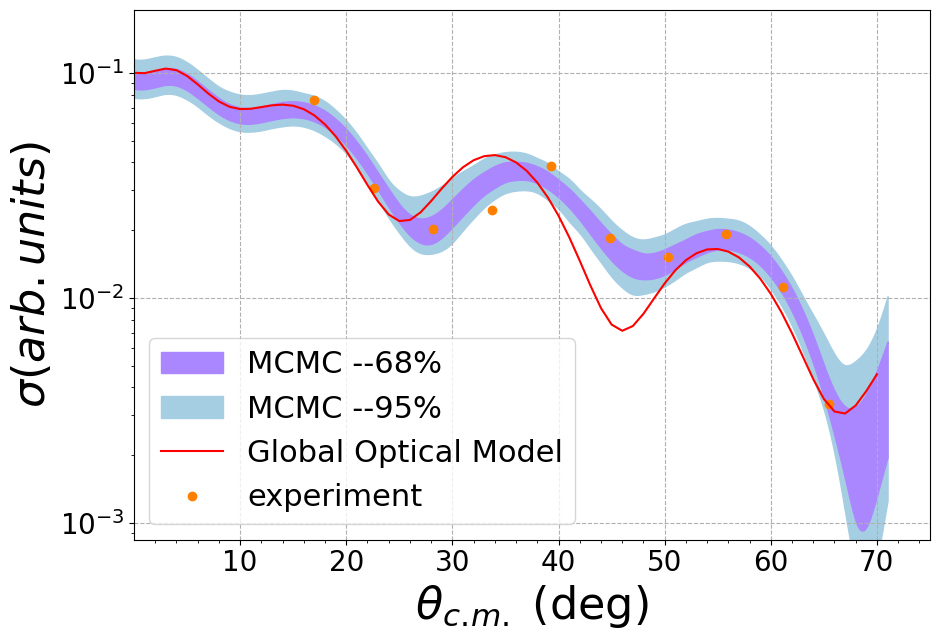

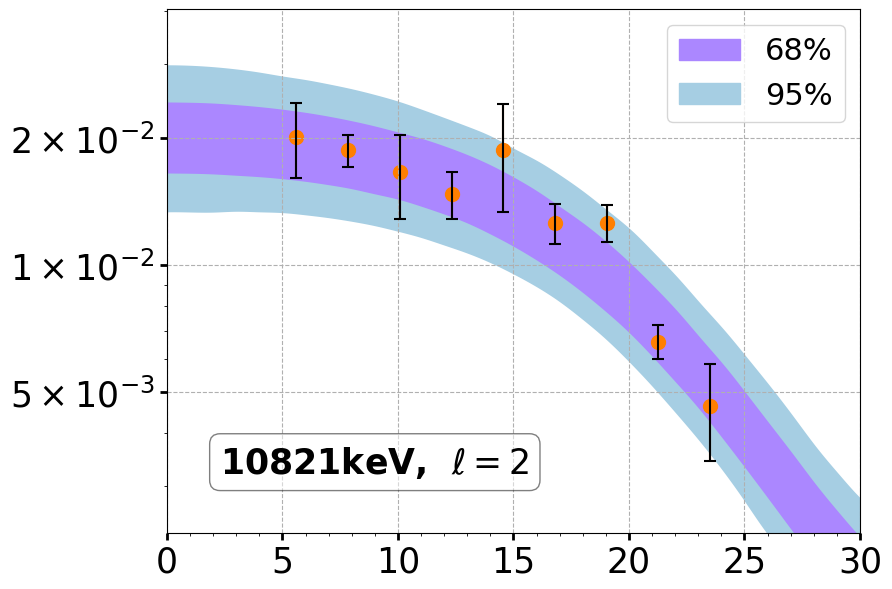

In [49]:
     
d = model.likelihood[0].data
plt.figure(figsize=(9.5, 6.5))
pfunk.utilities.plot_ci(all_cs_elastic_Norm,colors=['#AB87FF','#a6cee3'])
plt.ylim(3e-4, 1)
plt.xlim(1e-4, 75)
ymin=min(d.sigma)/4
ymax=max(d.sigma)*2.5
plt.ylim(ymin,ymax)
plt.ylabel(r'$Yield(arb.units)$')
plt.xlabel(r'$\theta_{c.\!m.}$ (deg)')
# plt.title(level, fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.yticks([5e-2,1e-1,2e-1,4e-1],['$'+'{:.0e}'.format(num2tex(i))+'$'  for i in [5e-2,1e-1,2e-1,4e-1]],fontsize=20)
# ax.yaxis.set_major_formatter(LogFormatterMathtext())
plt.minorticks_on()
plt.tight_layout()
plt.grid(which='major', axis='both',linestyle='--')
if(True): ##plot global curve with legend
    import matplotlib.patches as mpatches
    model.run_fresco(model.x0)
    cs = pfunk.fresco_classes.read_cross('fort.201')
    glob, =plt.plot(cs.theta, cs.sigma*10**model.x0[0], label='Global Optical Model', lw=1.5,color='red')
    data_label, =plt.plot(d.theta, d.sigma, linestyle="None",marker='o',zorder=1, color="#ff7f00",label='experiment')
    pop_a = mpatches.Patch(color='#AB87FF', label='MCMC --68%')
    pop_b = mpatches.Patch(color='#a6cee3', label='MCMC --95%')
    plt.legend(handles=[pop_a,pop_b,glob,data_label],fontsize=22)
    plt.ylabel(r'$\sigma(arb.units)$')
plt.savefig(path_plots+'/'+level+'_ES.png')

d = model.likelihood[1].data
# Read J and orbital to be updated to the figure
orbital=Ref.loc[Ref['Level']==levelnum]['Orbital'].values
jf=Ref.loc[Ref['Level']==levelnum]['Jf'].values[0]
if 'twol' in method and len(orbital)>2:
    orbital=orbital[1:3]
ls=[]
for tempstr in orbital:
    if tempstr.find('2s')>=0:
        ls.append(0)
    if tempstr.find('p')>=0:
        ls.append(1)
    if tempstr.find('1d')>=0:
        ls.append(2)
    if tempstr.find('1f')>=0:
        ls.append(3)
    if tempstr.find('1g')>=0:
        ls.append(4)
# plt.figure(figsize=(9.5, 6.5))
fig, ax = plt.subplots(figsize=(9.5, 6.5))
plt.yscale('log')
if ('twol' in method):
    
    pfunk.utilities.plot_ci(all_cs_transfer_Norm,colors=['#AB87FF'], data=d,zorder=0,linewidth=4.0,markersize=10.0,levels=[68.0])
    pfunk.utilities.plot_ci(all_cs_transfer_Norm_l1,colors=[lcolor[ls[0]]], alpha=0.7,zorder=1,levels=[68.0])
    pfunk.utilities.plot_ci(all_cs_transfer_Norm_l2,colors=[lcolor[ls[1]]], alpha=0.7,zorder=2,levels=[68.0]) 

else:
    pfunk.utilities.plot_ci(all_cs_transfer_Norm, data=d,zorder=1,linewidth=4.0,markersize=10.0,colors=['#AB87FF','#a6cee3'])
# plt.ylim(min(d.sigma)/2, max(d.sigma)*2)
if 'twol' in method:
    ymin=min(d.sigma)/10
    ymax=max(d.sigma)*3
else:
    ymin=min(d.sigma)/2
    ymax=max(d.sigma)*2
if level in ['8358','7555','10712','10724','10731','10333','10660','9003']:
    ymin=ymin/5
if level in ['10712','9003','10731']:
    ymax=ymax*3
plt.ylim(ymin,ymax)
plt.xlim(0,30)
ylabels=[]
for i in [5e-4,1e-3,2e-3,5e-3,1e-2,2e-2,5e-2,1e-1,2e-1,5e-1]:
    if (i<ymax and i>ymin):
        ylabels.append(i)
plt.minorticks_on()
plt.yticks(ylabels,['$'+'{:.0e}'.format(num2tex(i))+'$'  for i in ylabels],fontsize=25)
plt.xticks(fontsize=25)
# ax.yaxis.set_major_formatter(LogFormatterMathtext())

plt.tight_layout()
plt.grid(which='major', axis='both',linestyle='--')
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.tick_params(axis='x',which='both',labelbottom=True)
plt.tick_params(length=5,width=2)
if 'twol' in method:
    xshift=0.4
    yshift=0.75
else:
    xshift=0.3
    yshift=0.17
if level in ['10660']:
    xshift=0.5
    yshift=0.17
if level=='10724':
    level='10712+10731'
    xshift=xshift+0.1
if level=='11390':
    level='11391'
if level=='8437':
    level='8439'
    xshift=xshift-0.15
if 'twol' in method:
    ax.text(0.05+xshift, 0.2+yshift, level+'keV'  , transform=ax.transAxes, fontsize=25,
                ha='center',va='top', bbox=props, color='black',weight='bold')
    if level=='8439':
        l12=mpatches.Patch(color='#AB87FF', label='mixed, '+' $\ell='+str(ls[0])+'+'+str(ls[1])+'$' )
        l1 = mpatches.Patch(color=lcolor[ls[0]], label='$J^\pi=1-$, $\ell='+str(ls[0])+'$' )
        l2 = mpatches.Patch(color=lcolor[ls[1]], label='$J^\pi=4+$, $\ell='+str(ls[1])+'$' )
    else:
        l12=mpatches.Patch(color='#AB87FF', label=' $\ell='+str(ls[0])+'+'+str(ls[1])+'$' )
        l1 = mpatches.Patch(color=lcolor[ls[0]], label=' $\ell='+str(ls[0])+'$' )
        l2 = mpatches.Patch(color=lcolor[ls[1]], label=' $\ell='+str(ls[1])+'$' )
    plt.legend(handles=[l12,l1,l2],fontsize=20)
elif '1p' in method:
    ax.text(xshift, yshift, level[0:level.find('_')]+'keV, '+' $\ell='+str(ls[0])+'$'  , transform=ax.transAxes, fontsize=25,
            ha='center',va='top', bbox=props, color='black',weight='bold')
            
    plt.legend(handles=[pop_a,pop_b],fontsize=22,loc=legendloc)
else:
    ax.text(xshift, yshift, level+'keV, '+' $\ell='+str(ls[0])+'$'  , transform=ax.transAxes, fontsize=25,
            ha='center',va='top', bbox=props, color='black',weight='bold')
    pop_a = mpatches.Patch(color='#AB87FF', label='68%')
    pop_b = mpatches.Patch(color='#a6cee3', label='95%')
    plt.legend(handles=[pop_a,pop_b],fontsize=22,loc='upper right')
plt.xlabel(None)
plt.ylabel(None)
plt.errorbar(d.theta, d.sigma, yerr=d.erry,linestyle='None', marker='o',\
             markersize=0, zorder=4, capsize=4,linewidth=1.5,capthick=1.5,color="black")

if 'twol' in method:
    plt.savefig(path_plots+'/'+level+'_TR.png')
else:
    plt.savefig(path_plots+'/'+level+'_TR.png')

In [50]:
path_plots

'/home/kaixin/Documents/23NaHe3d_Analysis/Plots/'

### Scale by the normalization and C2S values

In [51]:

# all_cs_elastic_Norm = copy.deepcopy(all_cs_elastic)
# all_cs_transfer_Norm = copy.deepcopy(all_cs_transfer)
# all_cs_transfer_Norm_l1 = copy.deepcopy(all_cs_transfer)
# all_cs_transfer_Norm_l2 = copy.deepcopy(all_cs_transfer_l2)
# for i in range(N):
#     all_cs_elastic_Norm[i].sigma = 10**(s_samp[i,iNorm])*all_cs_elastic[i].sigma
#     if ('twol' in method):
# #         alpha=0.7737467799020796
#         alpha=np.percentile(s[:, iAlpha], [16, 50, 84])[2]
# #         alpha=np.percentile(s[:, iAlpha], [84])[0]
#         all_cs_transfer_Norm[i].sigma = (1-alpha)*10**(s_samp[i,iNorm])*s_samp[i,iC2S]*all_cs_transfer_l2[i].sigma \
#         + (alpha)*10**(s_samp[i,iNorm])*s_samp[i,iC2S]*all_cs_transfer[i].sigma
#         all_cs_transfer_Norm_l1[i].sigma = (alpha)*10**(s_samp[i,iNorm])*s_samp[i,iC2S]*all_cs_transfer[i].sigma        
#         all_cs_transfer_Norm_l2[i].sigma = (1-alpha)*10**(s_samp[i,iNorm])*s_samp[i,iC2S]*all_cs_transfer_l2[i].sigma
# #         all_cs_transfer_Norm[i].sigma = (1-alpha)*10**(s_samp[i,iNorm])*s_samp[i,iC2S]*all_cs_transfer_l2[i].sigma \
# #         + (alpha)*10**(s_samp[i,iNorm])*s_samp[i,iC2S]*all_cs_transfer[i].sigma
# #         all_cs_transfer_Norm_l1[i].sigma = (alpha)*10**(s_samp[i,iNorm])*s_samp[i,iC2S]*all_cs_transfer[i].sigma        
# #         all_cs_transfer_Norm_l2[i].sigma = (1-alpha)*10**(s_samp[i,iNorm])*s_samp[i,iC2S]*all_cs_transfer_l2[i].sigma
#     else:
#         all_cs_transfer_Norm[i].sigma = 10**(s_samp[i,iNorm])*s_samp[i,iC2S]*all_cs_transfer[i].sigma

#     #all_cs_elastic_Norm[i].sigma = all_cs_elastic[i].sigma
#     #all_cs_transfer_Norm[i].sigma = s_samp[i,iC2S]*all_cs_transfer[i].sigma


### Finally, plot the cross section with credibility intervals

In [52]:
# d = model.likelihood[0].data
# fig, ax = plt.subplots(figsize=(9.5, 6.5))
# pfunk.utilities.plot_ci(all_cs_elastic_Norm, data=d,markersize=8.0,colors=['#AB87FF','#a6cee3'])
# #pfunk.utilities.plot_ci(all_cs_elastic_Norm, data=d)
# plt.ylim(3e-4, 1)
# plt.xlim(1e-4, 75)
# ymin=min(d.sigma)/4
# ymax=max(d.sigma)*2.5
# plt.ylim(ymin,ymax)
# plt.ylabel(r'$Yield(arb.units)$')
# plt.xlabel(r'$\theta_{c.\!m.}$ (deg)')
# # plt.title(level, fontsize=16)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# # plt.yticks([5e-2,1e-1,2e-1,4e-1],['$'+'{:.0e}'.format(num2tex(i))+'$'  for i in [5e-2,1e-1,2e-1,4e-1]],fontsize=20)
# # ax.yaxis.set_major_formatter(LogFormatterMathtext())
# plt.minorticks_on()
# plt.tight_layout()
# plt.grid(which='major', axis='both',linestyle='--')
# # Add legend with the custom patches
# if(True): ##plot global curve with legend
#     import matplotlib.patches as mpatches
#     model.run_fresco(model.x0)
#     cs = pfunk.fresco_classes.read_cross('fort.201')
#     glob, =plt.plot(cs.theta, cs.sigma*10**model.x0[0], label='Global Optical Model', lw=1.5,color='red')
#     data_label, =plt.plot(d.theta, d.sigma, linestyle="None",marker='o',zorder=1, color="#ff7f00",label='experiment')
#     blue_95 = mpatches.Patch(color='#a6cee3', label='95%')
#     blue_68 = mpatches.Patch(color='#AB87FF', label='68%')
#     plt.legend(handles=[blue_95,blue_68,glob,data_label],fontsize=22)
#     plt.ylabel(r'$\sigma(arb.units)$')
# plt.errorbar(d.theta, d.sigma, yerr=d.erry,linestyle='None', marker='o',\
#          markersize=0, zorder=4, capsize=4,linewidth=1.5,capthick=1.5,color="black")
# # plt.savefig(path_plots+'/'+level+'_ES.png')

### Plot transfer data

In [53]:
# d = model.likelihood[1].data
# # plt.figure(figsize=(9.5, 6.5))
# fig, ax = plt.subplots(figsize=(9.5, 6.5))
# plt.yscale('log')
# if ('twol' in method):
#     pfunk.utilities.plot_ci(all_cs_transfer_Norm,colors=['#AB87FF'], data=d,zorder=0,linewidth=4.0,markersize=10.0,levels=[68.0])
#     # pfunk.utilities.plot_ci(all_cs_transfer_Norm_l2,colors=['#8B2252','#FFC1C1'], alpha=0.4,zorder=1)
#     # pfunk.utilities.plot_ci(all_cs_transfer_Norm_l1,colors=['#FFB90F','#EEDC82'], alpha=0.4,zorder=2) 
#     pfunk.utilities.plot_ci(all_cs_transfer_Norm_l1,colors=['#9BEFA5'], alpha=0.7,zorder=1,levels=[68.0])
#     pfunk.utilities.plot_ci(all_cs_transfer_Norm_l2,colors=['#C08497'], alpha=0.7,zorder=2,levels=[68.0]) 

# else:
#     pfunk.utilities.plot_ci(all_cs_transfer_Norm,zorder=1,linewidth=4.0,colors=['#AB87FF','#a6cee3'])
# # plt.ylim(min(d.sigma)/2, max(d.sigma)*2)
# ymin=min(d.sigma)/2
# if 'twol' in method:
#     ymin=min(d.sigma)/20
# ymax=max(d.sigma)*2
# # ymin=min(d.sigma)/3
# # if 'twol' in method:
# #     ymin=min(d.sigma)/20
# # ymax=max(d.sigma)*3
# plt.ylim(ymin,ymax)
# plt.xlim(0,30)
# # plt.yscale('linear')
# # plt.legend(['95%','68%',level],loc='best')
# ylabels=[]
# for i in [5e-4,1e-3,2e-3,5e-3,1e-2,2e-2,5e-2,1e-1,2e-1,5e-1]:
#     if (i<ymax and i>ymin):
#         ylabels.append(i)
# plt.minorticks_on()
# plt.yticks(ylabels,['$'+'{:.0e}'.format(num2tex(i))+'$'  for i in ylabels],fontsize=25)
# plt.xticks(fontsize=25)
# # ax.yaxis.set_major_formatter(LogFormatterMathtext())

# plt.tight_layout()
# plt.grid(which='major', axis='both',linestyle='--')
# props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# # ax.text(0.3, 0.1, '8437keV $1^-$ $\ell=1$' , transform=ax.transAxes, fontsize=26,
# #             ha='center',va='top', bbox=props, color='#FFB90F')
# # ax.text(0.3, 0.2, '8439keV $4^+$ $\ell=2$' , transform=ax.transAxes, fontsize=26,
# #             ha='center',va='top', bbox=props, color='#8B2252')
# plt.tick_params(axis='x',which='both',labelbottom=True)
# plt.tick_params(length=5,width=2)
# xshift=0.3
# yshift=0.17
# if 'twol' in method:
#     ax.text(0.18+xshift, 0.2+yshift, level+'keV'  , transform=ax.transAxes, fontsize=25,
#                 ha='center',va='top', bbox=props, color='black',weight='bold')
#     ax.text(0.48+xshift, 0.2+yshift, '$\ell=1$' , transform=ax.transAxes, fontsize=25,
#                 ha='center',va='top', bbox=props, color='#9BEFA5',weight='bold')
#     ax.text(0.48+xshift, 0.05+yshift, '$\ell=2$' , transform=ax.transAxes, fontsize=25,
#                 ha='center',va='top', bbox=props, color='#C08497',weight='bold')
# #     ax.text(0.4+0.2, 0.07+yshift+0.05, '$\ell=0$' , transform=ax.transAxes, fontsize=26,
# #                 ha='center',va='top', bbox=props, color='#FFB90F')
# #     ax.text(0.4+0.2, 0.2+yshift+0.05, '$\ell=2$' , transform=ax.transAxes, fontsize=26,
# #                 ha='center',va='top', bbox=props, color='#8B2252')
# #     plt.savefig(path_plots+'/'+level+'_twol.png')
# else:
#     ax.text(xshift, yshift, level+'keV, '+' $\ell=1$'  , transform=ax.transAxes, fontsize=25,
#             ha='center',va='top', bbox=props, color='black',weight='bold')

# # Add legend with the custom patches
# if(True): ##plot global curve with legend
#     data_label, =plt.plot(d.theta, d.sigma, linestyle="None",marker='o',markersize=8.0,zorder=1, color="#ff7f00",label='experiment')
#     pop_a = mpatches.Patch(color='#AB87FF', label='MCMC --68%')
#     pop_b = mpatches.Patch(color='#a6cee3', label='MCMC --95%')
#     plt.legend(handles=[pop_a,pop_b,data_label],fontsize=20)

# plt.xlabel(None)
# plt.ylabel(None)
# # plt.ylabel(r'$Yield(arb.units)$')
# plt.xlabel(r'$\theta_{c.\!m.}$ (deg)')
# plt.errorbar(d.theta, d.sigma, yerr=d.erry,linestyle='None', marker='o',\
#              markersize=0, zorder=4, capsize=4,linewidth=1.5,capthick=1.5,color="black")
# # if 'twol' in method:
# #     plt.savefig(path_plots+'/'+level+method+'_TR.png')
# # else:
# #     plt.savefig(path_plots+'/'+level+'_TR.png')
# plt.show()
# plt.close('all')

### Print (2J+1)C2S. You need to change J manually.

In [54]:
if ('twol' in method):
    s1=np.percentile(s[:, iC2S]*s[:, iAlpha], [16, 50, 84])
    s2=np.percentile(s[:, iC2S]*(1-s[:, iAlpha]), [16, 50, 84])
    txt = "{3} = ${0:.4f}_{{{1:.4f}}}^{{{2:.4f}}}$"
    txt=txt.format(2/3*s1[1],2/3*(-s1[1]+s1[0]),2/3*(s1[2]-s1[1]), '${C^2S}_{'+level+'}$')
    display(Math(txt))
    txt = "{3} = ${0:.4f}_{{{1:.4f}}}^{{{2:.4f}}}$"
    txt=txt.format(2/3*s2[1],2/3*(-s2[1]+s2[0]),2/3*(s2[2]-s2[1]), '${C^2S}_{'+level+'}$')
    display(Math(txt))
else:
    i=1
    mcmc = np.percentile(s[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{3} = ${0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}$"
    txt = txt.format(mcmc[1]*2/3, q[0]*2/3, q[1]*2/3, '${C^2S}_{'+level+'}$')
    display(Math(txt))

<IPython.core.display.Math object>

In [55]:
[0.0287*9,0.0090*9,-0.0064*9]

[0.2583, 0.08099999999999999, -0.057600000000000005]

In [56]:
fresco_path

'/home/kaixin/Documents/23NaHe3d_Analysis/FrescoInputFiles/Na23He3d_10821keV.in'

In [57]:
print(1,2)

1 2


In [58]:
pwd

'/home/kaixin/Documents/23NaHe3d_Analysis/FrescoTemp/20250701_16:16'

In [59]:
len(s)-len(snew)

0

In [60]:
0.0439419*9

0.39547709999999997

In [64]:
aso=0.7643
aso1=0.0535
aso=aso+aso1*23**(1/3)
aso

0.9164468834220587